In [150]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Q1: GLCM Matrix

In [151]:
def GLCM(image, d, theta):
    """
    Parameters
    ------------
    image: the input image
    d: (dx, dy) displacement vector   
    convolution: orientation {0, 45, 90, 135} 
         
    """
    m, n = image.shape[0] ,image.shape[1]
    C = np.zeros((256, 256))  #co-occurrence matrix 
 
    for i in range(m):
        for j in range(n):
            if theta == 0:  # horizontal
                if j + d[1] < n: # check boundary
                    val1 = image[i][j]
                    val2 = image[i][j + d[1]]
                    C[val1][val2] += 1
            if theta == 45:  # front diagonal
                if j + d[1] < n and i - d[0] >= 0: 
                    val1 = image[i][j]
                    val2 = image[i - d[0]][j + d[1]]
                    C[val1][val2] += 1
            if theta == 90:   # vertical 
                if i - d[0] >= 0:
                    val1 = image[i][j]
                    val2 = image[i - d[0]][j]
                    C[val1][val2] += 1
            if theta == 135: # back diagonal 
                if j - d[1] >= 0 and i - d[0] >= 0:
                    val1 = image[i][j]
                    val2 = image[i - d[0]][j - d[1]]
                    C[val1][val2] += 1
    return C


### Q2: LBP

In [152]:
def LBP(image):
    pad_image = np.pad(image,(1,1),'constant') # pad zero
    m, n = image.shape[0] ,image.shape[1]
    new_img = np.zeros((m, n))
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            lbp = str()
            for r in range(i - 1, i + 2):
                for c in range(j - 1, j + 2):    
                    if r != i or c != j:
                        if pad_image[r][c] > pad_image[i][j]:  # neighbor greater than center
                            lbp += '1'
                        else:
                            lbp += '0'
            new_img[i - 1][j - 1] = int(lbp, 2)  #convert to decimal
         #   print(lbp)
    return new_img

### Q3: Texture Based Segmentation

In [676]:
def texSeg(image):
    # angles = [0,  45, 90, 135]
    angles = [90]
    d = [2,2] # displament
    k = 20  # dimension of sub images
    m, n = image.shape[0] ,image.shape[1]

    w_contrast = np.zeros((256, 256))
    w_dissimilarity = np.zeros((256, 256))
    w_homogeneity = np.zeros((256, 256))

    for i in range(256):
        for j in range(256):
            w_contrast[i][j] = (i-j)**2
            w_dissimilarity[i][j] = np.abs(i - j)
            w_homogeneity[i][j] = 1 / (1 + (i - j)**2)

    cells_x = m // k #number of sub images in x dim
    cells_y = n // k
    features = np.zeros((cells_x, cells_y, len(angles)*1)) 
    for x in range(cells_x):
        for y in range(cells_y):
            feature = []
            for angle in angles:
                glcm = GLCM(image[x*k:(x+1)*k, y*k:(y+1)*k], d, angle)
                # glcm = glcm / np.sum(glcm)
                contrast = np.sum(glcm*w_contrast)
                dissimilarity = np.sum(glcm*w_dissimilarity)
                # ASM = np.sqrt(np.sum(np.square(glcm)))
                # homogeneity = np.sum(w_homogeneity*glcm)
                feature.extend([contrast])

            features[x,y] = np.array(feature)
    features = (features-features.mean(axis=(0,1)))/features.std(axis=(0,1))
            
    return features

    

### Test

In [155]:
#  test for Q1
image = np.array([[0,0,1,1], [0, 0, 1, 1], [0, 2, 2, 2], [2, 2, 3, 3]])  # the example in lecture ppt
glcm = GLCM(image, (1,1), 0)
print(glcm[:4,:4])

[[2. 2. 1. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 1.]
 [0. 0. 0. 1.]]


Text(0.5, 1.0, 'After LBP')

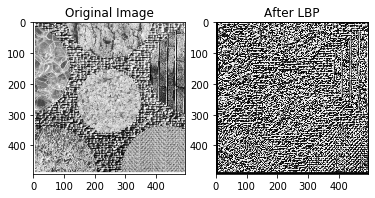

In [195]:
# test for Q2
image = cv2.imread('./test.png',0)
lbp = LBP(image)
plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image')
plt.subplot(122),plt.imshow(lbp,cmap = 'gray')
plt.title('After LBP')


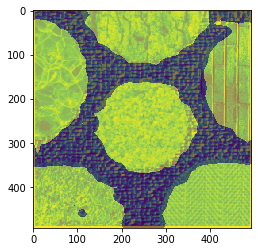

In [683]:
# Test for Q3
# Tried different properity that can get from GLCM matrix, contrast works the best, but only able to clustering the image into 2 groups
image = cv2.imread('./test.png',0)
features = texSeg(image)

from skimage.transform import resize
mask = resize(features.sum(axis=2), image.shape[:2], order=1)

plt.imshow(image)
plt.imshow(mask<0.3,alpha=0.5)